In [8]:
import numpy as np
import pandas as pd
import nltk
import string
import re
import matplotlib.pyplot as plt
from scipy import stats
from keras.preprocessing import sequence
from keras.layers import  Input, Dense, Flatten, Add,\
    BatchNormalization, Concatenate, Dropout, Activation, Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.models import Model, load_model
import tensorflow as tf
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, Callback
import keras.backend as K

In [201]:
from sklearn.metrics import roc_auc_score
# need to modify to work for 6 labels
class ROCCallBack(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        y_pred_val = self.model.predict(self.x_val)
        roc_train, roc_val = [], []
        for counter, i in enumerate(output_names):            
            roc_train.append(roc_auc_score(self.y[counter], y_pred[counter].flatten()))            
            roc_val.append(roc_auc_score(self.y_val[counter], y_pred_val[counter].flatten())) 
        print()
        print('roc-auc: %s - roc-auc_val: %s' % (str(round(np.mean(roc_train),4)),str(round(np.mean(roc_val),4))))
        print('Val ROCs: ' + '    '.join([output_names[counter] + ': ' + str(round(i,4))for counter, i in enumerate(roc_val)]))

In [10]:
def flatten(x):
    if isinstance(x, (np.ndarray, list, tuple, pd.Series)):
        lst = []
        for i in x:
            lst += flatten(i)
        return lst
    else:
        return [x]

#### Load Data

In [152]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [153]:
# use linear preds as pseudo-labeled data
linear_preds = pd.read_csv('data/answers/linear_ensemble_0.85_09724.csv')

In [154]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [155]:
pseudo = test.merge(linear_preds, how = 'left', on='id').sample(int(train.shape[0]*0.3), random_state = 10).round()
pseudo[output_names] = pseudo[output_names].astype(int)
train = train.append(pseudo, ignore_index = True).sample(frac=1, random_state = 10).reset_index(drop = True)

In [156]:
train[output_names].apply(pd.value_counts)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,184379,205582,194779,206878,196491,205786
1,23063,1860,12663,564,10951,1656


In [157]:
output_names = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [158]:
train['tokens'] = train['comment_text'].apply(lambda x: list(filter(lambda z: len(z), map(lambda y: y.lower(), nltk.word_tokenize(x)))))
test['tokens'] = test['comment_text'].apply(lambda x: list(filter(lambda z: len(z), map(lambda y: y.lower(), nltk.word_tokenize(x)))))

In [159]:
train['tokens'].head()

0    [``, ==, more, help, with, a, specific, editor...
1    [==, wtf, !, !, ==, i, hate, bill, gates, with...
2    [most, certainly, ,, if, you, can, specify, yo...
3    [==, will, i, be, given, proper, chance, and, ...
4    [==, hi, ,, i, 'm, on, the, internet, using, a...
Name: tokens, dtype: object

In [160]:
train['tokLength'] = train['tokens'].apply(lambda x: len(x))

In [161]:
train['tokLength'].describe()

count    207442.000000
mean         79.208584
std         121.973466
min           1.000000
25%          20.000000
50%          42.000000
75%          87.000000
max        4948.000000
Name: tokLength, dtype: float64

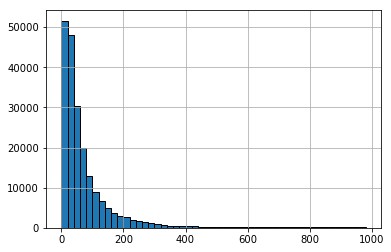

In [162]:
train['tokLength'].hist(bins = range(0, 1000, 20),linewidth = 1, edgecolor = 'black' )
plt.show()
#looks like max_length of 500 should be good

In [163]:
stats.percentileofscore(train['tokLength'].values, 500)

98.235892442224809

In [164]:
max_length = 500

What are the most common words in the texts?

In [165]:
dist = nltk.FreqDist(flatten(train.tokens.values))

In [166]:
print('Number of total tokens in the training set:', dist.N())
print('Number of unique tokens in the training set:', dist.B())

Number of total tokens in the training set: 16431187
Number of unique tokens in the training set: 340323


In [167]:
dist.most_common(n=50)

[('.', 633575),
 ('the', 626620),
 (',', 598275),
 ('to', 372198),
 ("''", 321518),
 ('i', 294813),
 ('of', 282480),
 ('and', 280093),
 ('a', 273294),
 ('you', 270456),
 ('is', 230871),
 ('``', 202560),
 ('that', 202415),
 ('it', 188039),
 ('in', 182256),
 ('!', 166867),
 (':', 147354),
 ('for', 128326),
 ('this', 123310),
 ('not', 120640),
 (')', 112932),
 ('on', 111684),
 ('(', 105495),
 ('be', 105143),
 ('as', 96791),
 ('?', 94081),
 ('are', 92822),
 ('have', 91918),
 ("'s", 85430),
 ('your', 78390),
 ('do', 78187),
 ('with', 75141),
 ('if', 73187),
 ("n't", 72892),
 ('article', 71634),
 ('was', 71175),
 ('or', 66008),
 ('but', 64915),
 ('my', 55866),
 ('wikipedia', 55835),
 ('page', 55721),
 ('an', 55695),
 ('from', 51870),
 ('by', 51234),
 ('at', 49739),
 ('can', 46681),
 ('about', 46564),
 ('so', 45523),
 ('me', 45036),
 ('what', 44734)]

#### Load GloVe

In [168]:
f = open('data/glove.42B.300d.txt', 'r', encoding = 'utf-8')

In [169]:
all_unique_tokens = set(flatten(train.tokens.values)).union(set(flatten(test.tokens.values)))

In [170]:
embeddings = {}
for line in f:
    values = line.split()
    word = values[0]
    # Whole GloVe embeddings doesn't fit in my GPU memory, so only take words which appear in data for now. 
    # Can always swap weights for embedding layer after model training
    if word in all_unique_tokens:
        coefs = np.array(values[1:], dtype = 'float32')
        embeddings[word] = coefs

In [171]:
np.random.seed(10)
embeddings['<UNK>'] = np.random.normal(scale = 0.6,size = embeddings['.'].shape)

What are the most common words not in the vocab?

In [172]:
notInVocab = []
for i in dist.most_common():
    if i[0] not in embeddings.keys() and i[1]>100:
        notInVocab.append((i[0], i[1]))

In [173]:
notInVocab

[('==', 26630),
 ('•', 6630),
 ('*', 5106),
 ('style=', 2441),
 ('|-', 2289),
 ('youfuck', 2078),
 ('~~~~', 1830),
 ('·', 1395),
 ('|style=', 1175),
 (':i', 1031),
 ('f5fffa', 1012),
 ('dixz', 1000),
 ('width=', 994),
 ('||', 994),
 ('..', 962),
 ('—preceding', 723),
 ('====', 696),
 ('border:1px', 675),
 ('yourselfgo', 621),
 ('cellpadding=', 587),
 ('//en.wikipedia.org/w/index.php', 581),
 ('و', 552),
 ('bitchbot', 499),
 ('//', 494),
 ("'image", 491),
 ('→', 463),
 ('philippineslong', 420),
 ('つ', 399),
 ('◕_◕', 399),
 ('oompapa', 384),
 ('*the', 383),
 ('|class=', 382),
 ('three-revert', 380),
 ('===', 376),
 ('jelaton', 375),
 ('mainpagebg', 367),
 ('در', 351),
 ("sex'butt", 350),
 ('pro-assad.hanibal911you', 345),
 ('\u200e', 342),
 ('an/i', 339),
 ("'fuck", 334),
 ('bitches.fuck', 333),
 ('deneid', 331),
 ('rice=', 330),
 ('zeuphoris', 330),
 ('cellspacing=', 326),
 ("'the", 312),
 ('pagedelete', 312),
 ('notrhbysouthbanof', 308),
 ('cuntliz', 308),
 ('*how', 307),
 ('admin-', 2

#### Data Preparation

In [174]:
idx2word = {count:i for count, i in enumerate(embeddings.keys())}
word2idx = {idx2word[i]: i for i in idx2word.keys()}

In [175]:
print(word2idx['testing'])
print(word2idx['<UNK>'])
print(idx2word[123])

1674
211860
could


In [176]:
n_factors = 300
vocab_size = len(embeddings)

In [177]:
zero_vector_idx = vocab_size #place blank character last
idx2word[zero_vector_idx] = ''
word2idx[''] = zero_vector_idx

In [178]:
def create_emb():
    emb = np.zeros((vocab_size+1,n_factors), dtype = 'float32')
    for i in range(0, vocab_size):
        word = idx2word[i]
        emb[i,:] = embeddings[word] #each row is a word
    return emb

In [179]:
emb = create_emb()

In [180]:
emb.shape

(211862, 300)

In [181]:
# parse train/test sets
table = str.maketrans("","", string.punctuation)
def toksToInds(listToks):
    ans = []
    for count, i in enumerate(listToks):
        try:
            ans.append(word2idx[i])
        except KeyError:
            temp = i.translate(table)
            if temp and temp in word2idx.keys():
                ans.append(word2idx[temp])
            else:
                ans.append(word2idx['<UNK>'])        
    return np.array(ans)

train['idxInput'] = train['tokens'].apply(toksToInds)
test['idxInput'] = test['tokens'].apply(toksToInds)

In [182]:
train_mat = sequence.pad_sequences(train['idxInput'].values, maxlen = max_length, value = zero_vector_idx)
test_mat = sequence.pad_sequences(test['idxInput'].values, maxlen = max_length, value = zero_vector_idx)

In [183]:
train_mat.shape

(207442, 500)

In [184]:
' '.join([idx2word[i] for i in train_mat[0,:]])

"                                                                                                                                                                                                                                                                                                                                                                      `` <UNK> more help with a specific editor <UNK> will not stop harassing me on north carolina tar heels related articles . he continually edits out any changes and uses poor reasoning to do so such as `` '' lack of citations '' '' regarding almost any statement . he baits people into <UNK> and carries an extremely poor tone and lack of civility towards his fellow editors . he has had several admin interventions for his behavior , yet wo n't stop . i can not interact with him , and have requested in the past we work things out amicably . his most recent target of contention is the north carolina tar heels men 's basketball page . check

In [185]:
# train test split
indexTrain = np.random.choice(range(train_mat.shape[0]), size = int(0.9*train_mat.shape[0]), replace = False)
indexVal = list(set(range(train_mat.shape[0])) - set(indexTrain))
dataInputTrain = train_mat[indexTrain]
dataInputVal = train_mat[indexVal]
traindf = train.loc[indexTrain]
valdf = train.loc[indexVal]

In [186]:
valdf[output_names].apply(lambda x: pd.value_counts(np.round(x)))

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,18379,20545,19432,20695,19619,20572
1,2366,200,1313,50,1126,173


#### Modelling

In [187]:
# simple starter
# vec_input = Input(shape = (max_length,))
# x = Embedding(vocab_size+1, n_factors, input_length=max_length,weights = [emb], trainable = False)(vec_input)
# x = Conv1D(64,7,activation = 'relu', padding = 'same')(x)
# x = MaxPooling1D(2)(x)
# # x = Dropout(0.2)(x)

# x = Conv1D(64,7,activation = 'relu', padding = 'same')(x)
# x = GlobalMaxPooling1D()(x)
# x = Dropout(0.5)(x)

# x = Dense(32, activation = 'relu', kernel_regularizer=regularizers.l2(1e-4))(x)
# x = Dense(len(output_names), activation = 'sigmoid')(x)

# model = Model(inputs = vec_input, outputs = x)
# model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
# model.summary()

In [188]:
vec_input = Input(shape = (max_length,))
x = Embedding(vocab_size+1, n_factors, input_length=max_length,weights = [emb], trainable = False)(vec_input)
x = BatchNormalization(axis = -1)(x)
#conv 1
x = Conv1D(32, 7, activation = 'relu', padding = 'same')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)

#conv 2
x = Conv1D(64, 7, activation = 'relu', padding = 'same')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)

#conv 3
x = Conv1D(64, 7, activation = 'relu', padding = 'same')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)

#conv 4
x = Conv1D(128, 7, activation = 'relu', padding = 'same')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.2)(x)

# #conv 5
# x = Conv1D(128, 7, activation = 'relu', padding = 'same')(x)
# x = BatchNormalization(axis = -1)(x)
# x = MaxPooling1D(pool_size = 2)(x)
# x = Dropout(0.2)(x)

#dense 1
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization(axis = -1)(x)
x = Dropout(0.4)(x)

#dense 2
x = Dense(128, activation = 'relu')(x)
x = BatchNormalization(axis = -1)(x)
x = Dropout(0.4)(x)

In [189]:
# add output layers
outputs = []
for i in output_names:
    intermediate_act = Dense(units = 128, activation = 'relu')(x)
    intermediate_act = BatchNormalization(axis = -1)(intermediate_act)
    if i in ['toxic','obscene']:
        intermediate_act = Dense(units = 512, activation = 'relu')(intermediate_act)
        intermediate_act = BatchNormalization(axis = -1)(intermediate_act)
    outputs.append(Dense(units = 1, activation = 'sigmoid', name = i)(intermediate_act))

In [190]:
model = Model(inputs = vec_input, outputs = outputs)

In [191]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 500, 300)     63558600    input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 500, 300)     1200        embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 500, 32)      67232       batch_normalization_16[0][0]     
__________________________________________________________________________________________________
batch_norm

In [192]:
model.compile(Adam(1e-5), loss = 'binary_crossentropy')

In [202]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('weights/cnn_mdl', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')
tensor_board = TensorBoard(log_dir='./logs/run1', write_graph = False,)
roc_callback = ROCCallBack(training_data = [dataInputTrain, [traindf[i] for i in output_names]],
                          validation_data = [dataInputVal, [valdf[i] for i in output_names]])

In [204]:
K.set_value(model.optimizer.lr, 1e-3)
model.fit(x = dataInputTrain, 
          y = [traindf[i] for i in output_names],
         batch_size = 64, epochs = 200, validation_data = [dataInputVal, [valdf[i] for i in output_names]],
         callbacks=[earlyStopping, mcp_save, reduce_lr_loss, tensor_board, roc_callback])

Train on 186697 samples, validate on 20745 samples
Epoch 1/200
roc-auc: 0.9765 - roc-auc_val: 0.974                                                                                                     0.0656 - threat_loss: 0.0142 - insult_loss: 0.0759 - identity_hate_loss: 0.0307
Val ROCs: toxic: 0.9783    severe_toxic: 0.9888    obscene: 0.9873    threat: 0.9537    insult: 0.9812    identity_hate: 0.955
186697/186697 [==============================] - 307s 2ms/step - loss: 0.3201 - toxic_loss: 0.1090 - severe_toxic_loss: 0.0248 - obscene_loss: 0.0656 - threat_loss: 0.0141 - insult_loss: 0.0759 - identity_hate_loss: 0.0307 - val_loss: 0.3650 - val_toxic_loss: 0.1231 - val_severe_toxic_loss: 0.0257 - val_obscene_loss: 0.0864 - val_threat_loss: 0.0121 - val_insult_loss: 0.0867 - val_identity_hate_loss: 0.0311
Epoch 2/200
roc-auc: 0.9792 - roc-auc_val: 0.974                                                                                                     0.0635 - threat_loss: 0.0137 - in

Epoch 12/200
roc-auc: 0.9899 - roc-auc_val: 0.9764                                                                                                    0.0423 - threat_loss: 0.0107 - insult_loss: 0.0545 - identity_hate_loss: 0.0249
Val ROCs: toxic: 0.9759    severe_toxic: 0.9896    obscene: 0.9884    threat: 0.9586    insult: 0.9834    identity_hate: 0.9623
186697/186697 [==============================] - 301s 2ms/step - loss: 0.2209 - toxic_loss: 0.0673 - severe_toxic_loss: 0.0212 - obscene_loss: 0.0423 - threat_loss: 0.0107 - insult_loss: 0.0545 - identity_hate_loss: 0.0249 - val_loss: 0.3512 - val_toxic_loss: 0.1243 - val_severe_toxic_loss: 0.0284 - val_obscene_loss: 0.0821 - val_threat_loss: 0.0107 - val_insult_loss: 0.0767 - val_identity_hate_loss: 0.0291
Epoch 13/200
roc-auc: 0.9899 - roc-auc_val: 0.9754                                                                                                    0.0410 - threat_loss: 0.0105 - insult_loss: 0.0535 - identity_hate_loss: 0.0244
V

Examining what the model got wrong

In [ ]:
pred_val = model.predict(dataInputVal)

In [332]:
# for count,i in enumerate(output_names):
#     print('---------------' + i + '---------------------')
#     dif = (valdf[i] - pred_val[count].flatten()).abs().sort_values(ascending = False)
#     most_dif = valdf.loc[dif.index[:2]]
#     for count2, j in enumerate(most_dif.iterrows()):
#         print('Predicted', pred_val[count].flatten()[valdf[i].index.get_loc(j[0])]
#               , 'Actual', j[1][i],
#              '\n',
#              j[1]['comment_text'])

#### Submission

In [205]:
pred = model.predict(test_mat)

In [206]:
for count,i in enumerate(output_names):
    test[i] = pred[count].flatten()

In [207]:
test[['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_csv('data/answers/cnn1.csv', index = False)

In [208]:
model_stopped = load_model('weights/cnn_mdl')

In [209]:
pred_stopped = model_stopped.predict(test_mat)

In [210]:
for count,i in enumerate(output_names):
    test[i] = pred[count].flatten()
test[['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_csv('data/answers/cnnStopped.csv', index = False)    